In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input

In [4]:
import json

In [5]:
import mlrose_hiive as ml
import time

In [6]:
data = pd.read_csv(r"heart.csv")
data.drop_duplicates(inplace=True)

In [7]:
categorical_features = ['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope', ]
continuous_features = [ col for col in data.columns.to_list()[1:-1] if col not in categorical_features ]

target = 'target'

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = data[categorical_features + continuous_features]
y = data[target]

_X_train, X_test, _y_train, y_test = train_test_split(X, y, train_size=0.88, random_state=1, shuffle=True, stratify=y)

preprocessor = ColumnTransformer(
                    transformers=[
                        ('cat', OneHotEncoder(), categorical_features),
                        ('num', StandardScaler(), continuous_features)
                    ]
                )

_X_train = preprocessor.fit_transform(_X_train)
X_test = preprocessor.transform(X_test)

In [10]:
runtime = {}

In [238]:
nnet = Sequential([
    Input(shape=(_X_train.shape[1],)),
    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(8, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

st = time.time()

history = nnet.fit(_X_train, _y_train,
                   epochs=100,
                   batch_size=32,
                   callbacks=[early_stopping],
                   verbose=0)

et = time.time()
runtime['nnet'] = et - st

In [11]:
st = time.time()

nn_rhc = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                 algorithm='random_hill_climb', max_iters=100000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=True, max_attempts=100, \
                                 random_state=3, curve=True)

nn_rhc.fit(_X_train, _y_train)

et = time.time()
runtime['rhc'] = et - st

In [12]:
schedule = ml.ExpDecay()

st = time.time()

nn_sa = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                 algorithm='simulated_annealing', schedule=schedule, max_iters=100000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=True, max_attempts = 100, \
                                 random_state = 3, curve=True)

nn_sa.fit(_X_train, _y_train)

et = time.time()
runtime['sa'] = et - st

In [150]:
schedule = ml.ExpDecay(10, 0.01)

st = time.time()

nn_sa2 = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                 algorithm='simulated_annealing', schedule=schedule, max_iters=100000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=True, max_attempts = 100, \
                                 random_state = 3, curve=True)

nn_sa2.fit(_X_train, _y_train)

et = time.time()
runtime['sa2'] = et - st

In [14]:
st = time.time()

nn_ga = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                 algorithm='genetic_alg', max_iters=500000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=True, max_attempts = 1000, \
                                 pop_size=400, mutation_prob=0.1, \
                                 random_state = 5, curve=True)

nn_ga.fit(_X_train, _y_train)

et = time.time()
runtime['ga'] = et - st

In [29]:
st = time.time()

nn_ga2 = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                 algorithm='genetic_alg', max_iters=1000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=True, max_attempts = 100, \
                                 pop_size=50, mutation_prob=0.25, \
                                 random_state = 5, curve=True)

nn_ga2.fit(_X_train, _y_train)

et = time.time()
runtime['ga2'] = et - st

In [144]:
st = time.time()

nn_ga3 = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                 algorithm='genetic_alg', max_iters=1000, \
                                 bias=True, is_classifier=True, learning_rate=0.01, \
                                 early_stopping=True, max_attempts = 100, \
                                 pop_size=25, mutation_prob=0.3, \
                                 random_state = 5, curve=True)

nn_ga3.fit(_X_train, _y_train)

et = time.time()
runtime['ga3'] = et - st

In [270]:
pd.DataFrame(runtime, index=['runtime'])[['nnet', 'rhc', 'sa', 'sa2', 'ga', 'ga2', 'ga3']]

,nnet,rhc,sa,sa2,ga,ga2,ga3
runtime,2.109291,177.816891,237.210855,241.648852,1051.559993,11.44545,15.542991


In [271]:
predictions = {
    'nnet': np.round(nnet.predict(X_test, verbose=0)).astype(int).flatten(),
    'rhc': nn_rhc.predict(X_test).reshape(y_test.shape),
    'sa': nn_sa.predict(X_test).reshape(y_test.shape),
    'sa2': nn_sa2.predict(X_test).reshape(y_test.shape),
    'ga': nn_ga.predict(X_test).reshape(y_test.shape),
    'ga2': nn_ga2.predict(X_test).reshape(y_test.shape),
    'ga3': nn_ga3.predict(X_test).reshape(y_test.shape)
}

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

nnet


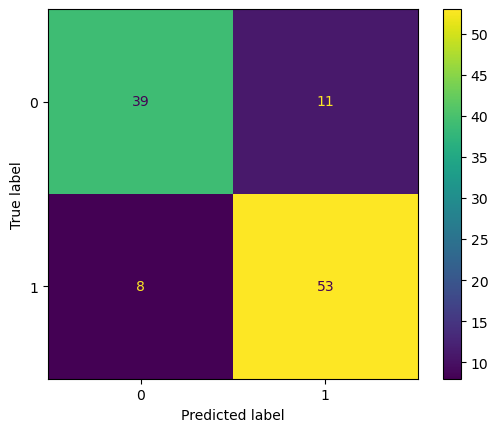

rhc


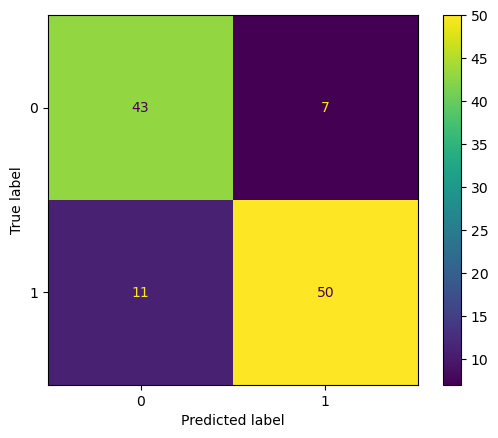

sa


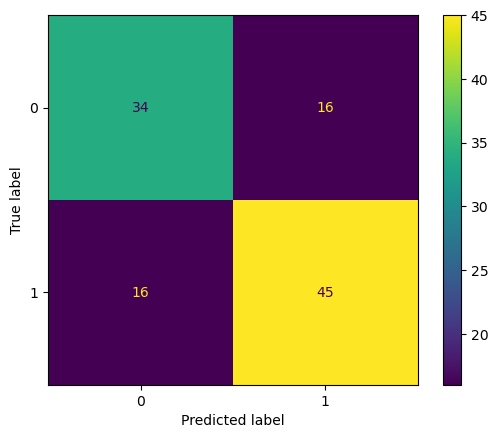

sa2


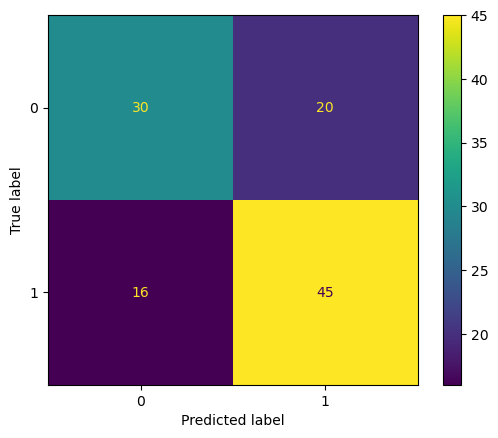

ga


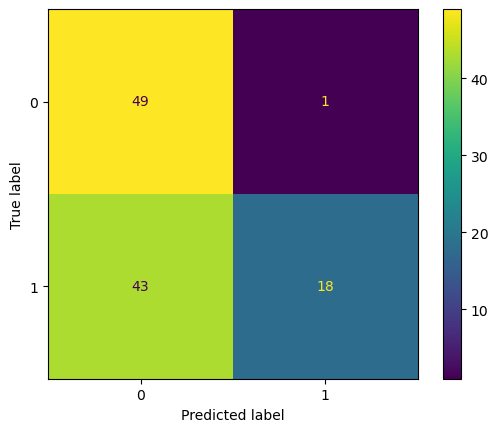

ga2


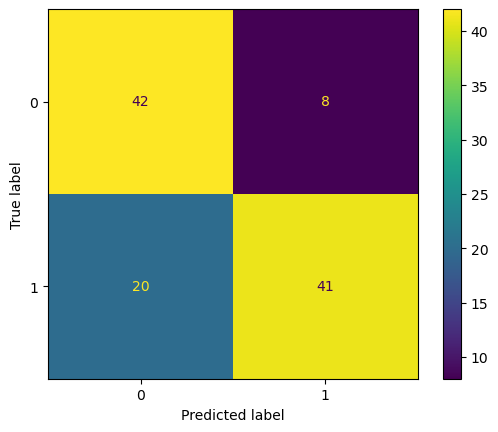

ga3


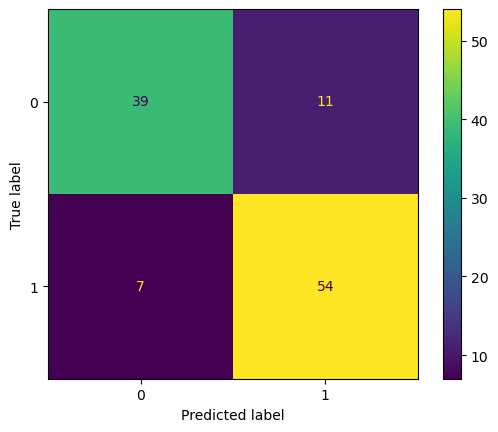

In [153]:
for clf in predictions.keys():
    print(clf)
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions[clf], labels=np.array([0, 1])),
                           display_labels=np.array([0, 1])
                          ).plot()

    plt.show()

In [154]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

In [272]:
pd.DataFrame(
    [
        {
            'accuracy_score': accuracy_score(y_test, predictions[clf]),
            'roc_auc_score': roc_auc_score(y_test, predictions[clf]),
            'f1_score': f1_score(y_test, predictions[clf]),
            'precision_score': precision_score(y_test, predictions[clf]),
            'recall_score': recall_score(y_test, predictions[clf])
        }
        
        for clf in predictions.keys()
    ],
    index=list(predictions.keys())
).style.highlight_max(color='lightgreen', axis=0)

,accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
nnet,0.846847,0.844426,0.861789,0.854839,0.868852
rhc,0.837838,0.839836,0.847458,0.877193,0.819672
sa,0.711712,0.708852,0.737705,0.737705,0.737705
sa2,0.675676,0.668852,0.714286,0.692308,0.737705
ga,0.603604,0.637541,0.450000,0.947368,0.295082
ga2,0.747748,0.756066,0.745455,0.836735,0.672131
ga3,0.837838,0.832623,0.857143,0.830769,0.885246


In [59]:
pd.DataFrame(
    {
        'algorithm': ['ga', 'ga2', 'ga3'],
        'iters': [500000, 1000, 5000],
        'attempts': [1000, 100, 250],
        'pop_size': [400, 50, 200],
        'mutation_prob': [0.1, 0.25, 0.2],
        'accuracy_score': [accuracy_score(y_test, predictions[clf]) for clf in ['ga', 'ga2', 'ga3']],
        'roc_auc_score': [roc_auc_score(y_test, predictions[clf]) for clf in ['ga', 'ga2', 'ga3']],
        'f1_score': [f1_score(y_test, predictions[clf]) for clf in ['ga', 'ga2', 'ga3']],
        'precision_score': [precision_score(y_test, predictions[clf]) for clf in ['ga', 'ga2', 'ga3']],
        'recall_score': [recall_score(y_test, predictions[clf]) for clf in ['ga', 'ga2', 'ga3']]
    }
)
# pd.DataFrame.corr()

,algorithm,iters,attempts,pop_size,mutation_prob,accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
0,ga,500000,1000,400,0.10,0.603604,0.637541,0.450000,0.947368,0.295082
1,ga2,1000,100,50,0.25,0.747748,0.756066,0.745455,0.836735,0.672131
2,ga3,5000,250,200,0.20,0.459459,0.508197,0.032258,1.000000,0.016393


In [156]:
fitness_curves = {
    # 'nnet': np.round(nnet.predict(X_test, verbose=0)).astype(int).flatten(),
    'rhc': nn_rhc.fitness_curve,
    'sa': nn_sa.fitness_curve,
    'sa2': nn_sa2.fitness_curve,
    'ga': nn_ga.fitness_curve,
    'ga2': nn_ga2.fitness_curve,
    'ga3': nn_ga3.fitness_curve
}

In [161]:
algs = ['rhc', 'sa', 'ga3']

In [162]:
nnet_curve_data = {}

for alg in algs:
    nnet_curve_data[alg] = pd.DataFrame(list(map(lambda x: (int(x[1]), x[0]), fitness_curves[f'{alg}'].tolist())), columns=['FEvals', 'Fit'])
    # nnet_curve_data[alg]['Time'] = np.linspace(0, ks_fit_df.query(f"(Algorithm == '{alg}') & (Size == {problem_sizes[-2]})").iloc[0].Time, ks_curve_data[alg].shape[0])

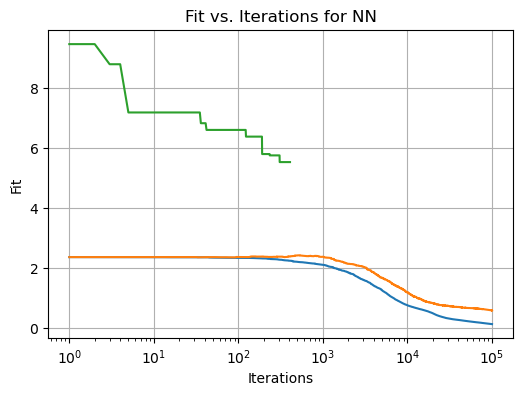

In [188]:
plt.figure(figsize=(6, 4))

for alg in algs:
    sns.lineplot(x=nnet_curve_data[alg].index.to_numpy()+1, y=nnet_curve_data[alg]['Fit'])

plt.title(f'Fit vs. Iterations for NN')
plt.xlabel('Iterations')
plt.ylabel('Fit')
plt.xscale('log')
plt.grid(True)
plt.show()

In [247]:
sa_runtime2 = {}
sa_models2 = {}

sa_schedules2 = [ml.ExpDecay(10), ml.ExpDecay(10, 0.01), ml.ExpDecay(10, 0.01, 0.0001)]
sa_attempts2 = [100]

In [248]:
for attempt in sa_attempts2:
    sa_runtime2[attempt] = {}
    sa_models2[attempt] = {}
    
    for decay, schedule in zip([1, 2, 3], sa_schedules2):
        
        st = time.time()
        
        sa_models2[attempt][decay] = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                         algorithm='simulated_annealing', schedule=schedule, max_iters=50000, \
                                         bias=True, is_classifier=True, learning_rate=0.01, \
                                         early_stopping=True, max_attempts = attempt, \
                                         random_state = 3, curve=True)
        
        sa_models2[attempt][decay].fit(_X_train, _y_train)
        
        et = time.time()
        sa_runtime2[attempt][decay] = et - st

In [254]:
sa_predictions2 = {}

for k1 in sa_models2.keys():
    for k2 in sa_models2[k1].keys():
        sa_predictions2[f'Setting: {k2}'] = sa_models2[k1][k2].predict(X_test).reshape(y_test.shape)

Setting: 1


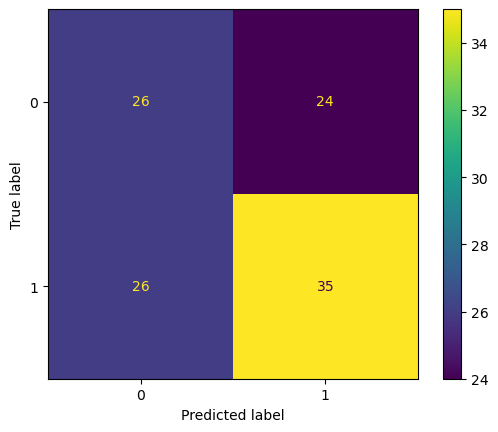

Setting: 2


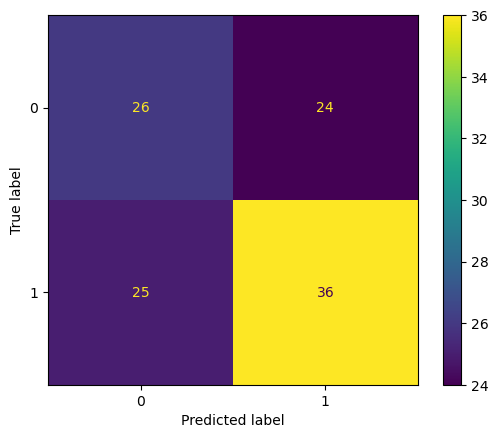

Setting: 3


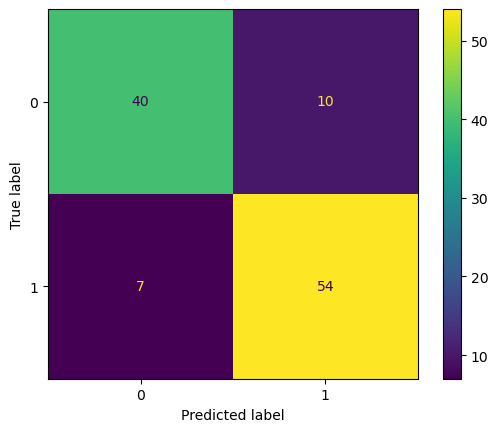

In [255]:
for clf in sa_predictions2.keys():
    print(clf)
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, sa_predictions2[clf], labels=np.array([0, 1])),
                           display_labels=np.array([0, 1])
                          ).plot()

    plt.show()

In [256]:
pd.DataFrame(
    [
        {
            'accuracy_score': accuracy_score(y_test, sa_predictions2[clf]),
            'roc_auc_score': roc_auc_score(y_test, sa_predictions2[clf]),
            'f1_score': f1_score(y_test, sa_predictions2[clf]),
            'precision_score': precision_score(y_test, sa_predictions2[clf]),
            'recall_score': recall_score(y_test, sa_predictions2[clf])
        }
        
        for clf in sa_predictions2.keys()
    ],
    index=list(sa_predictions2.keys())
).style.highlight_max(color='lightgreen', axis=0)

,accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
Setting: 1,0.549550,0.546885,0.583333,0.593220,0.573770
Setting: 2,0.558559,0.555082,0.595041,0.600000,0.590164
Setting: 3,0.846847,0.842623,0.864000,0.843750,0.885246


In [171]:
ga_runtime = {}
ga_models = {}

ga_pop_sizes = [25, 50, 100]
ga_mutation_probs = [0.25, 0.3, 0.4]

In [172]:
for pop_size in ga_pop_sizes:
    ga_runtime[pop_size] = {}
    ga_models[pop_size] = {}
    
    for mutation_prob in ga_mutation_probs:
        
        st = time.time()
        
        ga_models[pop_size][mutation_prob] = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                             algorithm='genetic_alg', max_iters=1000, \
                                             bias=True, is_classifier=True, learning_rate=0.01, \
                                             early_stopping=True, max_attempts = 100, \
                                             pop_size=pop_size, mutation_prob=mutation_prob, \
                                             random_state = 5, curve=True)
        
        ga_models[pop_size][mutation_prob].fit(_X_train, _y_train)
        
        et = time.time()
        ga_runtime[pop_size][mutation_prob] = et - st

In [218]:
ga_predictions = {}

for k1 in ga_models.keys():
    for k2 in ga_models[k1].keys():
        ga_predictions[f'PS: {k1}, MP: {k2}'] = ga_models[k1][k2].predict(X_test).reshape(y_test.shape)

PS: 25, MP: 0.25


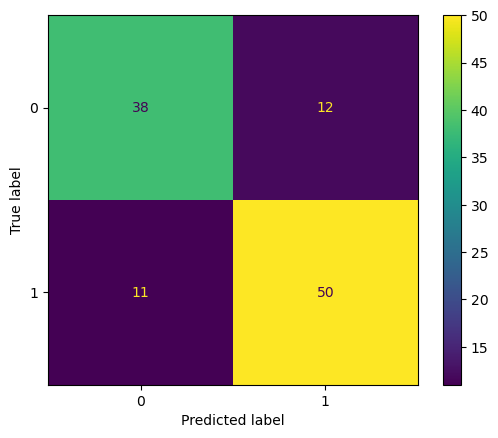

PS: 25, MP: 0.3


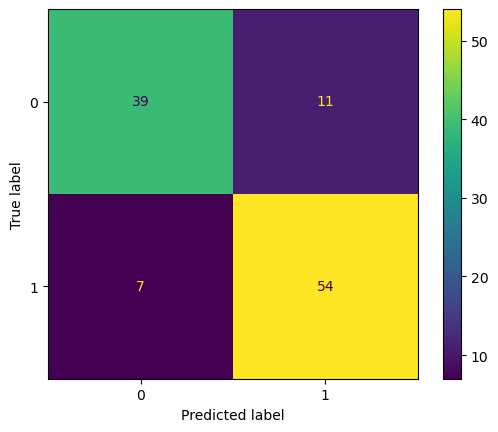

PS: 25, MP: 0.4


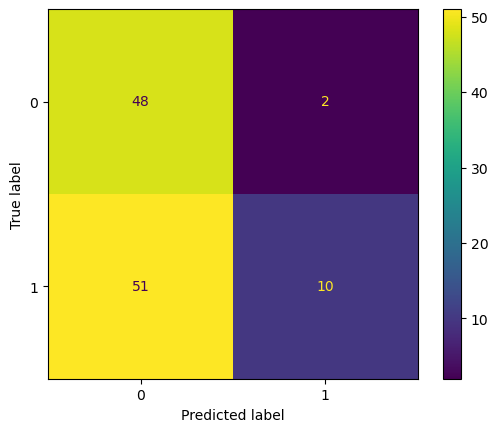

PS: 50, MP: 0.25


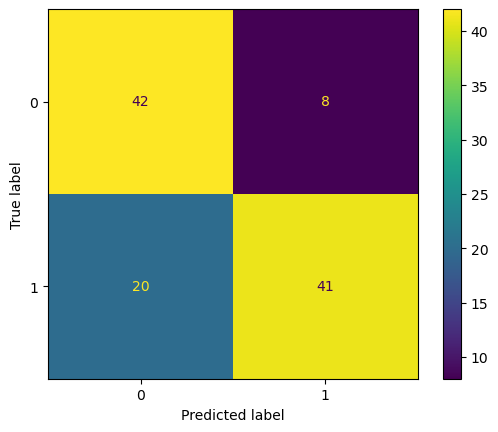

PS: 50, MP: 0.3


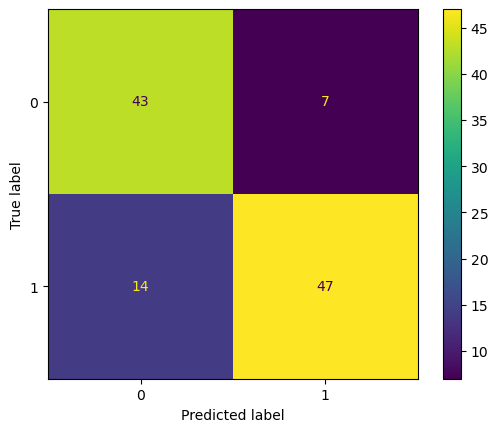

PS: 50, MP: 0.4


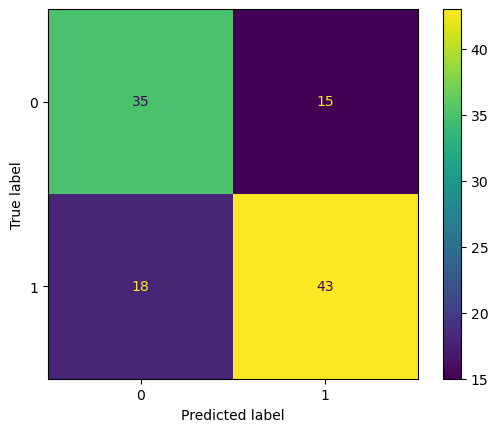

PS: 100, MP: 0.25


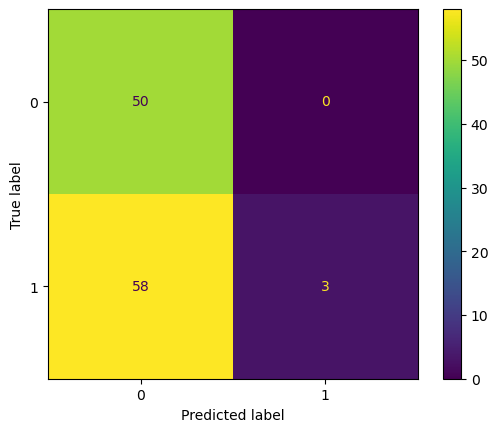

PS: 100, MP: 0.3


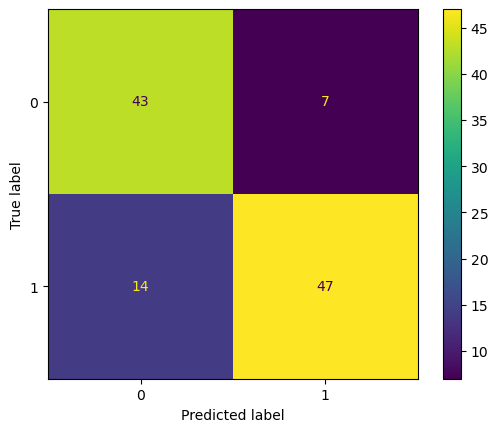

PS: 100, MP: 0.4


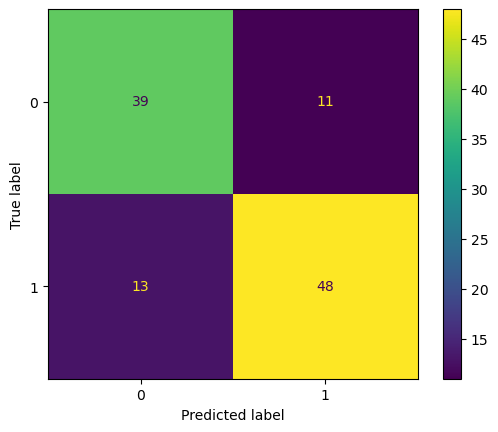

In [219]:
for clf in ga_predictions.keys():
    print(clf)
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, ga_predictions[clf], labels=np.array([0, 1])),
                           display_labels=np.array([0, 1])
                          ).plot()

    plt.show()

In [222]:
pd.DataFrame(
    [
        {
            'accuracy_score': accuracy_score(y_test, ga_predictions[clf]),
            'roc_auc_score': roc_auc_score(y_test, ga_predictions[clf]),
            'f1_score': f1_score(y_test, ga_predictions[clf]),
            'precision_score': precision_score(y_test, ga_predictions[clf]),
            'recall_score': recall_score(y_test, ga_predictions[clf])
        }
        
        for clf in ga_predictions.keys()
    ],
    index=list(ga_predictions.keys())
).style.highlight_max(color='lightgreen', axis=0)

,accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
"PS: 25, MP: 0.25",0.792793,0.789836,0.813008,0.806452,0.819672
"PS: 25, MP: 0.3",0.837838,0.832623,0.857143,0.830769,0.885246
"PS: 25, MP: 0.4",0.522523,0.561967,0.273973,0.833333,0.163934
"PS: 50, MP: 0.25",0.747748,0.756066,0.745455,0.836735,0.672131
"PS: 50, MP: 0.3",0.810811,0.815246,0.817391,0.870370,0.770492
"PS: 50, MP: 0.4",0.702703,0.702459,0.722689,0.741379,0.704918
"PS: 100, MP: 0.25",0.477477,0.524590,0.093750,1.000000,0.049180
"PS: 100, MP: 0.3",0.810811,0.815246,0.817391,0.870370,0.770492
"PS: 100, MP: 0.4",0.783784,0.783443,0.800000,0.813559,0.786885


In [258]:
rhc_net = nn_rhc
sa_net = sa_models2[100][3]
ga_net = ga_models[25][0.3]

In [259]:
pd.DataFrame(
    [
        {
            'Adam': runtime['nnet'],
            'RHC': runtime['rhc'],
            'SA': sa_runtime2[100][3],
            'GA': ga_runtime[25][0.3],
        }
    ],
    index=['runtime']
)

,Adam,RHC,SA,GA
runtime,2.109291,177.816891,113.387929,17.077989


In [260]:
pd.DataFrame(
    [
        {
            'RHC': rhc_net.fitness_curve[:,1].sum(),
            'SA': sa_net.fitness_curve[:,1].sum(),
            'GA': ga_net.fitness_curve[:,1].sum(),
        }
    ],
    index=['FEvals']
)

,RHC,SA,GA
FEvals,7.123979e+09,2.259069e+09,2182681.0


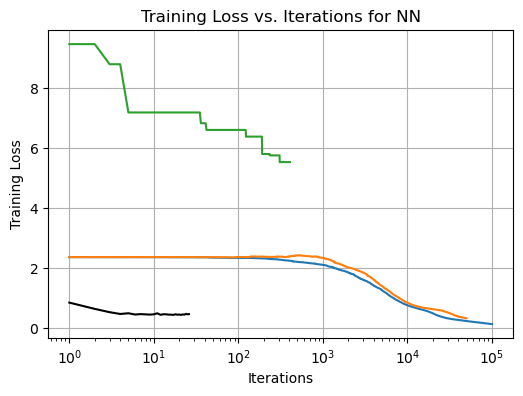

In [261]:
plt.figure(figsize=(6, 4))

plt.plot(list(range(1, rhc_net.fitness_curve[:,0].shape[0]+1)), rhc_net.fitness_curve[:,0])
plt.plot(list(range(1, sa_net.fitness_curve[:,0].shape[0]+1)), sa_net.fitness_curve[:,0])
plt.plot(list(range(1, ga_net.fitness_curve[:,0].shape[0]+1)), ga_net.fitness_curve[:,0])
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'], color='black')

plt.title(f'Training Loss vs. Iterations for NN')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.xscale('log')
plt.grid(True)
plt.show()

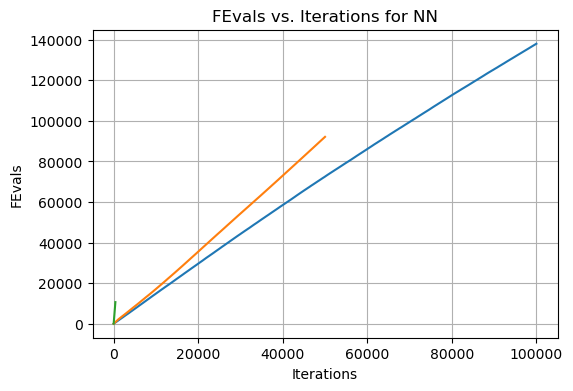

In [262]:
plt.figure(figsize=(6, 4))

plt.plot(list(range(1, rhc_net.fitness_curve[:,1].shape[0]+1)), rhc_net.fitness_curve[:,1])
plt.plot(list(range(1, sa_net.fitness_curve[:,1].shape[0]+1)), sa_net.fitness_curve[:,1])
plt.plot(list(range(1, ga_net.fitness_curve[:,1].shape[0]+1)), ga_net.fitness_curve[:,1])

plt.title(f'FEvals vs. Iterations for NN')
plt.xlabel('Iterations')
plt.ylabel('FEvals')
# plt.xscale('log')
plt.grid(True)
plt.show()

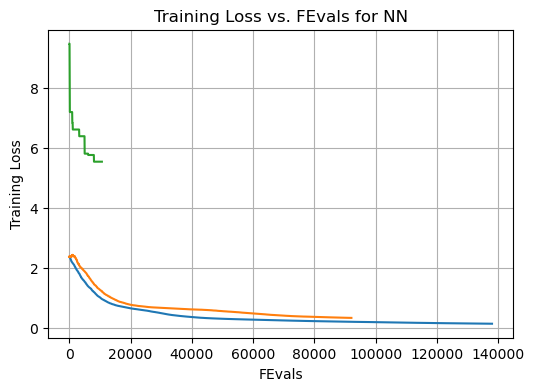

In [263]:
plt.figure(figsize=(6, 4))

plt.plot(rhc_net.fitness_curve[:,1], rhc_net.fitness_curve[:,0])
plt.plot(sa_net.fitness_curve[:,1], sa_net.fitness_curve[:,0])
plt.plot(ga_net.fitness_curve[:,1], ga_net.fitness_curve[:,0])

plt.title(f'Training Loss vs. FEvals for NN')
plt.xlabel('FEvals')
plt.ylabel('Training Loss')
# plt.xscale('log')
plt.grid(True)
plt.show()

In [264]:
final_predictions = {
    'adam': np.round(nnet.predict(X_test, verbose=0)).astype(int).flatten(),
    'rhc': rhc_net.predict(X_test).reshape(y_test.shape),
    'sa': sa_net.predict(X_test).reshape(y_test.shape),
    'ga': ga_net.predict(X_test).reshape(y_test.shape),
}

In [265]:
pd.DataFrame(
    [
        {
            'accuracy_score': accuracy_score(y_test, final_predictions[clf]),
            'roc_auc_score': roc_auc_score(y_test, final_predictions[clf]),
            'f1_score': f1_score(y_test, final_predictions[clf]),
            'precision_score': precision_score(y_test, final_predictions[clf]),
            'recall_score': recall_score(y_test, final_predictions[clf])
        }
        
        for clf in final_predictions.keys()
    ],
    index=list(final_predictions.keys())
).style.highlight_max(color='lightgreen', axis=0)

,accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
adam,0.846847,0.844426,0.861789,0.854839,0.868852
rhc,0.837838,0.839836,0.847458,0.877193,0.819672
sa,0.846847,0.842623,0.864000,0.843750,0.885246
ga,0.837838,0.832623,0.857143,0.830769,0.885246


adam


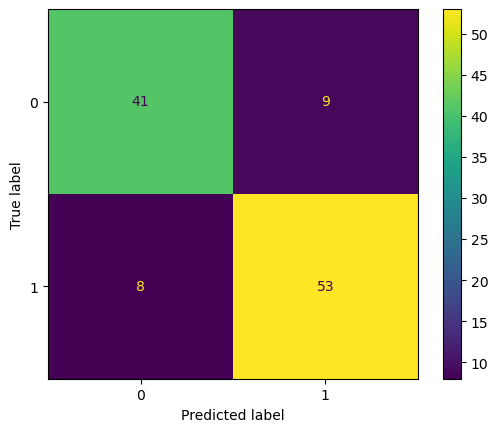

rhc


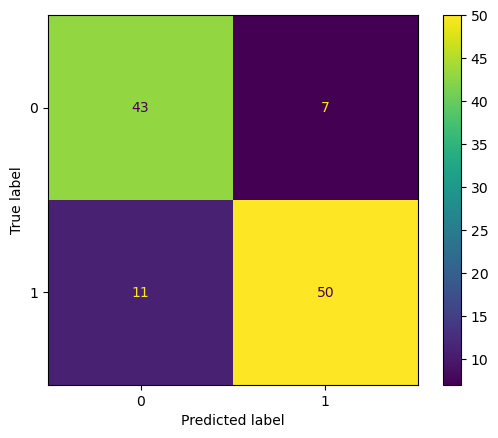

sa


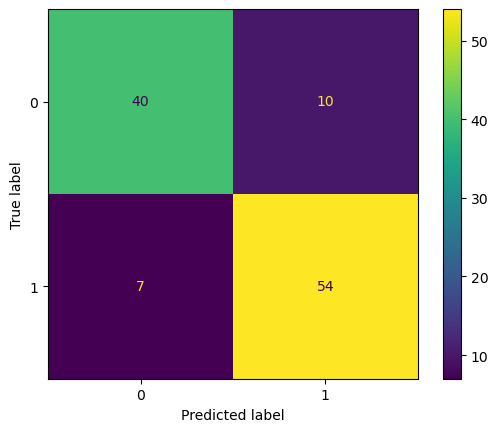

ga


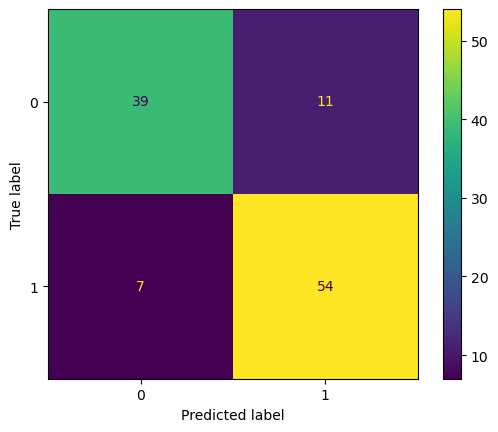

In [266]:
for clf in final_predictions.keys():
    print(clf)
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, final_predictions[clf], labels=np.array([0, 1])),
                           display_labels=np.array([0, 1])
                          ).plot()

    plt.show()

In [247]:
sa_runtime2 = {}
sa_models2 = {}

sa_schedules2 = [ml.ExpDecay(10), ml.ExpDecay(10, 0.01), ml.ExpDecay(10, 0.01, 0.0001)]
sa_attempts2 = [100]

In [248]:
for attempt in sa_attempts2:
    sa_runtime2[attempt] = {}
    sa_models2[attempt] = {}
    
    for decay, schedule in zip([1, 2, 3], sa_schedules2):
        
        st = time.time()
        
        sa_models2[attempt][decay] = ml.NeuralNetwork(hidden_nodes=[16, 8], activation='relu', \
                                         algorithm='simulated_annealing', schedule=schedule, max_iters=50000, \
                                         bias=True, is_classifier=True, learning_rate=0.01, \
                                         early_stopping=True, max_attempts = attempt, \
                                         random_state = 3, curve=True)
        
        sa_models2[attempt][decay].fit(_X_train, _y_train)
        
        et = time.time()
        sa_runtime2[attempt][decay] = et - st

In [254]:
sa_predictions2 = {}

for k1 in sa_models2.keys():
    for k2 in sa_models2[k1].keys():
        sa_predictions2[f'Setting: {k2}'] = sa_models2[k1][k2].predict(X_test).reshape(y_test.shape)

Setting: 1


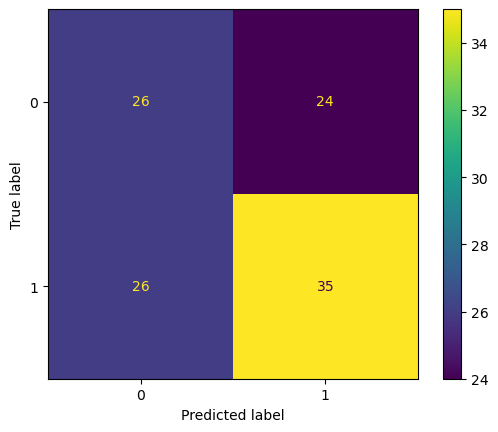

Setting: 2


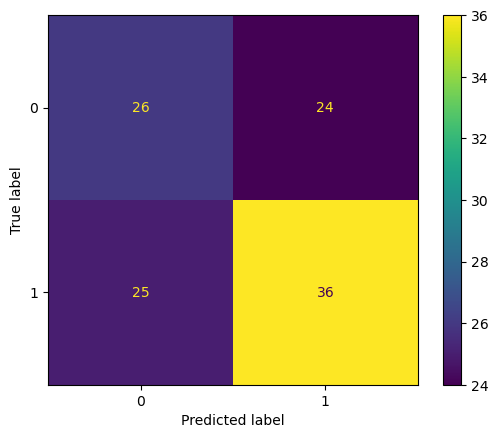

Setting: 3


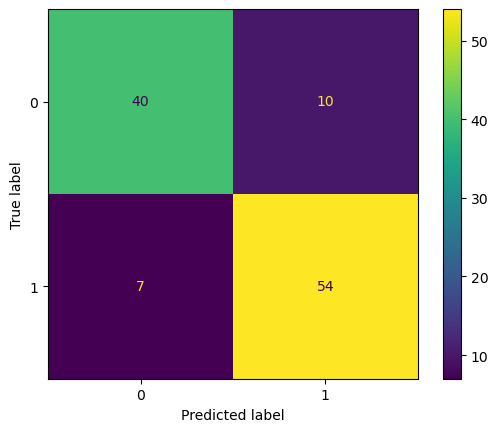

In [255]:
for clf in sa_predictions2.keys():
    print(clf)
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, sa_predictions2[clf], labels=np.array([0, 1])),
                           display_labels=np.array([0, 1])
                          ).plot()

    plt.show()

In [256]:
pd.DataFrame(
    [
        {
            'accuracy_score': accuracy_score(y_test, sa_predictions2[clf]),
            'roc_auc_score': roc_auc_score(y_test, sa_predictions2[clf]),
            'f1_score': f1_score(y_test, sa_predictions2[clf]),
            'precision_score': precision_score(y_test, sa_predictions2[clf]),
            'recall_score': recall_score(y_test, sa_predictions2[clf])
        }
        
        for clf in sa_predictions2.keys()
    ],
    index=list(sa_predictions2.keys())
).style.highlight_max(color='lightgreen', axis=0)

,accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
Setting: 1,0.549550,0.546885,0.583333,0.593220,0.573770
Setting: 2,0.558559,0.555082,0.595041,0.600000,0.590164
Setting: 3,0.846847,0.842623,0.864000,0.843750,0.885246
